In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import shap
from shap.maskers import Independent
from shap.plots import colors
from copy import deepcopy
import numpy as np
import pandas as pd
import pickle
import cloudpickle
from util import plot_decision_boundary, encode_one_hot, reduce_multiclass_proba_diff_shap_values
from helper_models import RuleClassifier
from difference_models import BinaryDifferenceClassifier, MulticlassDifferenceClassifier
%matplotlib inline

# Setup Task

In [3]:
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1, class_sep=0.75, random_state=4, n_classes=3)
feature_names = np.array(['x1', 'x2'])
n_features = len(feature_names)
n_samples = X.shape[0]

In [4]:
lm = LogisticRegression()
lm.fit(X, y)
lm.intercept_, lm.coef_

(array([-0.09291127, -0.25811169,  0.35102296]),
 array([[-2.06429271, -0.17864006],
        [ 1.24803884, -1.53632348],
        [ 0.81625387,  1.71496354]]))

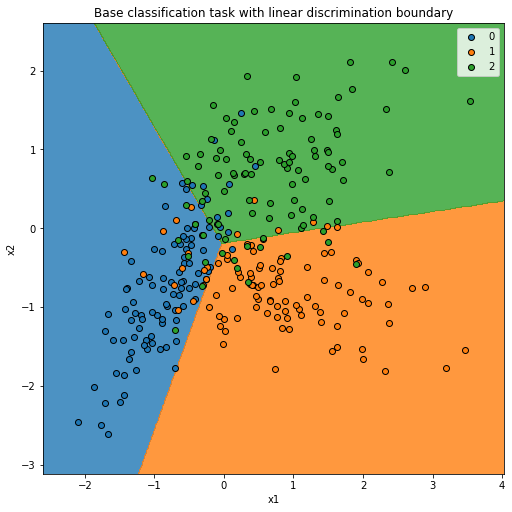

In [5]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
plot_decision_boundary(lm.predict, data=X, z=y, class_names=lm.classes_,
                       title='Base classification task with linear discrimination boundary',
                       feature_names=feature_names, fig=fig, ax=ax)

In [6]:
clf_a = lm

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class ModifiedClassifier(BaseEstimator, ClassifierMixin):
    
    def  __init__(self, base_model):
         self.base_model = base_model
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        return self
    
    def predict(self, X):
        X2 = X.copy()
        X2[X[:, 0] > 0, 1] += 0.5
        return self.base_model.predict(X2)
    
clf_b = ModifiedClassifier(lm)
clf_b.fit(X, y)

ModifiedClassifier(base_model=LogisticRegression())

# Find Differences

In [8]:
binary_diff_clf = BinaryDifferenceClassifier(clf_a, clf_b)
binary_diff_clf.fit(X, y)
binary_label_diff = binary_diff_clf.predict(X)

In [9]:
diff_clf = MulticlassDifferenceClassifier(clf_a, clf_b)
diff_clf.fit(X, y)
label_diff = diff_clf.predict(X)

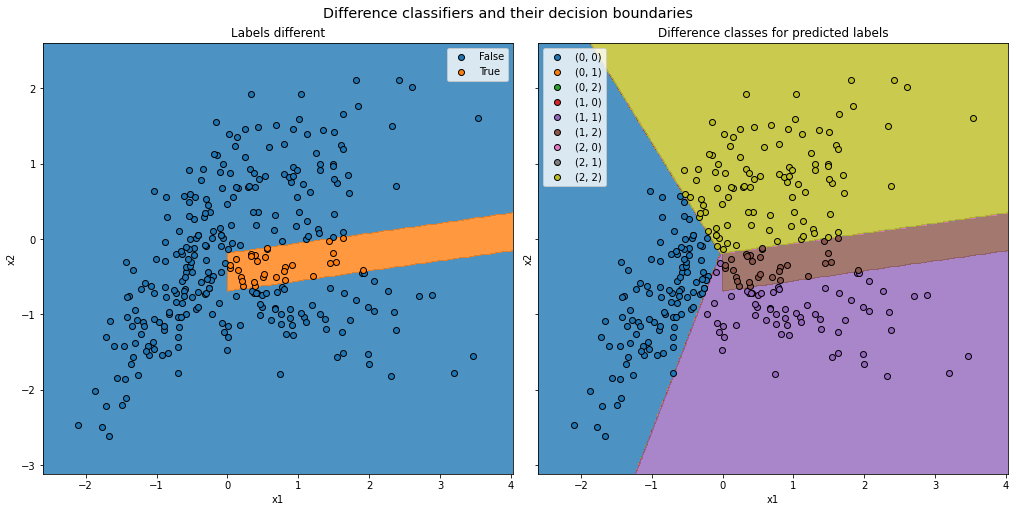

In [10]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(2*7, 7), constrained_layout=True)
fig.suptitle('Difference classifiers and their decision boundaries', fontsize='x-large')
plot_decision_boundary(binary_diff_clf.predict, data=X, z=binary_label_diff, class_names=binary_diff_clf.classes_,
                       title='Labels different', feature_names=feature_names, fig=fig, ax=axs[0])
plot_decision_boundary(diff_clf.predict, data=X,z=label_diff, class_names=diff_clf.class_tuples_,
                       title='Difference classes for predicted labels', feature_names=feature_names, fig=fig, ax=axs[1])

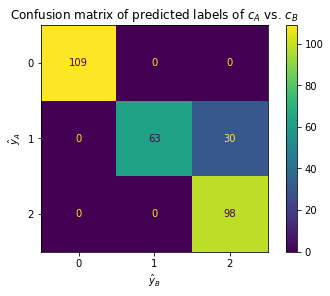

In [11]:
pred_a = clf_a.predict(X)
pred_b = clf_b.predict(X)
cm = confusion_matrix(pred_a, pred_b, labels=clf_a.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_a.classes_)
fig, ax = plt.subplots(constrained_layout=True)
disp.plot(ax=ax)
ax.set_title('Confusion matrix of predicted labels of $c_A$ vs. $c_B$')
ax.set_ylabel('$\hat{y}_A$')
ax.set_xlabel('$\hat{y}_B$')
plt.show()

# Explain using Interpretability Methods

In [12]:
background_data = X
def explain(predict):
    masker = Independent(data=background_data, max_samples=background_data.shape[0])
    explainer = shap.Explainer(predict, masker, feature_names=feature_names)
    shap_values = explainer(X)
    return shap_values

Generate SHAP values for the proposed multiclass difference classifier:

In [13]:
%%time
n_diff_classes = len(diff_clf.classes_)
diff_shap_values = explain(lambda X: encode_one_hot(diff_clf.predict(X), n_diff_classes))

CPU times: user 4.88 s, sys: 113 ms, total: 4.99 s
Wall time: 5.58 s


Derive SHAP values for the binary difference classifier from the multiclass difference SHAP values, because it is faster:

In [14]:
binary_diff_shap_values = reduce_multiclass_proba_diff_shap_values(diff_shap_values)
indices = np.indices(y.shape).ravel()
is_pred_diff = binary_diff_clf.predict(X)
is_pred_equal = ~is_pred_diff

## Feature importance

Throughout the analysis, order features based on their importance for the binary difference classifier:

In [15]:
feature_importances = binary_diff_shap_values.abs.mean(axis=0)
feature_order = np.flip(feature_importances.values.argsort())

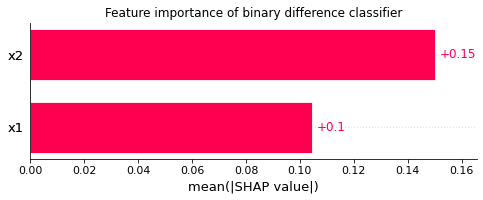

In [137]:
plt.title('Feature importance of binary difference classifier')
shap.plots.bar(feature_importances, order=feature_order, max_display=n_features)

Using the multiclass difference classifier, we can split this up into the individual classes

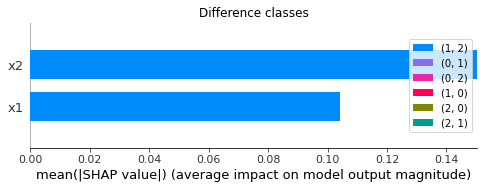

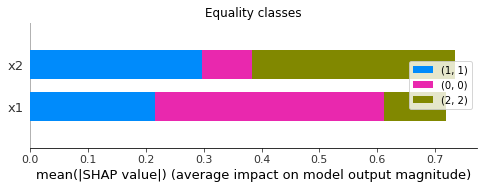

In [151]:
for class_indices, class_title in [(diff_clf.difference_classes_, 'Difference classes'),
                                   (diff_clf.equality_classes_, 'Equality classes')]:
    diff_shap_values_list = [values.T for values in diff_shap_values.values[:, :, class_indices].T]
    class_names = [str(class_tuple) for class_tuple in diff_clf.class_tuples_[class_indices]]
    shap.summary_plot(diff_shap_values_list, X, feature_names=feature_names, class_names=class_names, show=False)
    plt.legend(loc='right')
    plt.title(class_title)
    plt.show()

Derive a class order and the number of informative classes (minimal set of classes, whichs SHAP values make up more than 90%)

In [114]:
def get_class_order(class_indices, diff_shap_values, threshold = 0.9):
    shap_values = diff_shap_values[:, :, class_indices]
    class_importances = np.abs(shap_values.values).mean(axis=1).mean(axis=0)
    class_order = np.flip(np.argsort(class_importances))
    n_informative_classes = 1 + np.where(np.cumsum(class_importances[class_order]) / np.sum(class_importances) > threshold)[0][0]
    return class_order, class_importances, n_informative_classes

In [116]:
difference_class_order, difference_class_importances, n_informative_difference_classes = \
    get_class_order(diff_clf.difference_classes_, diff_shap_values)
equality_class_order, equality_class_importances, n_informative_equality_classes = \
    get_class_order(diff_clf.equality_classes_, diff_shap_values)

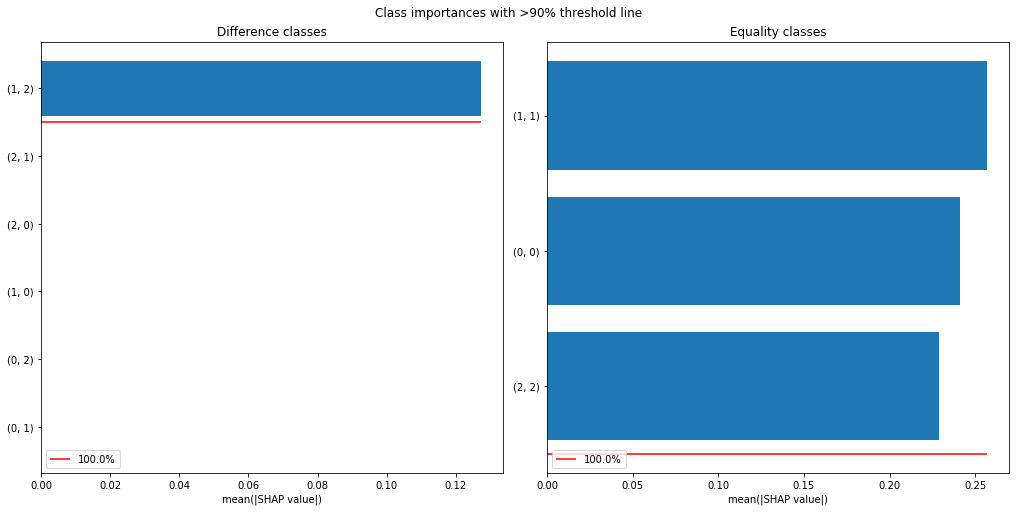

In [154]:
fig, axs = plt.subplots(ncols=2, figsize=(2*7, 7), constrained_layout=True)
fig.suptitle('Class importances with >90% threshold line')
for class_title, ax, class_indices, class_importances, n_informative_classes in [
        ('Difference classes', axs[0], diff_clf.difference_classes_[difference_class_order], difference_class_importances[difference_class_order], n_informative_difference_classes),
        ('Equality classes', axs[1], diff_clf.equality_classes_[equality_class_order], equality_class_importances[equality_class_order], n_informative_equality_classes)]:
    y_pos = np.arange(len(class_indices))
    class_names = [str(class_tuple) for class_tuple in diff_clf.class_tuples_[class_indices]]
    threshold_importance = np.sum(class_importances[:n_informative_classes]) / np.sum(class_importances)
    y_pos_threshold_line = n_informative_classes - 0.5
    ax.barh(y_pos, class_importances, align='center')
    ax.hlines(y_pos_threshold_line, 0.0, class_importances.max(), colors='red', label=f'{np.round(threshold_importance * 100, 1)}%')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(class_names)
    ax.invert_yaxis()
    ax.set_xlabel('mean(|SHAP value|)')
    ax.set_title(class_title)
    ax.legend()
plt.show()

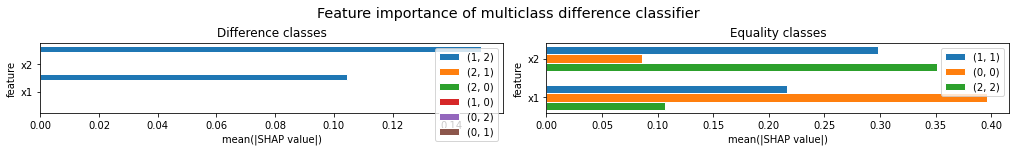

In [155]:
bar_width = 0.22
fig, axs = plt.subplots(ncols=2, figsize=(2*7, n_features), constrained_layout=True)
fig.suptitle('Feature importance of multiclass difference classifier', fontsize='x-large')
for class_indices, title, ax in [(diff_clf.difference_classes_[difference_class_order], 'Difference classes', axs[0]),
                                 (diff_clf.equality_classes_[equality_class_order], 'Equality classes', axs[1])]:
    importances = np.abs(diff_shap_values.values[:, :, class_indices]).mean(0).T
    rects = [i * bar_width + np.arange(importances.shape[1]) for i in range(importances.shape[0])]
    ax.set_title(title)
    for class_idx, rect, importance in zip(class_indices, rects, importances[:, feature_order]):
        ax.barh(rect, importance, height=bar_width, edgecolor='white', label=str(diff_clf.class_tuples_[class_idx]))
    ax.set_ylabel('feature')
    ax.set_xlabel('mean(|SHAP value|)')
    ax.set_yticks([r + bar_width * (len(class_indices) - 1)/2 for r in range(importances.shape[1])])
    ax.set_yticklabels(feature_names[feature_order])
    ax.invert_yaxis()
    ax.legend()
plt.show()

## Visualize SHAP values

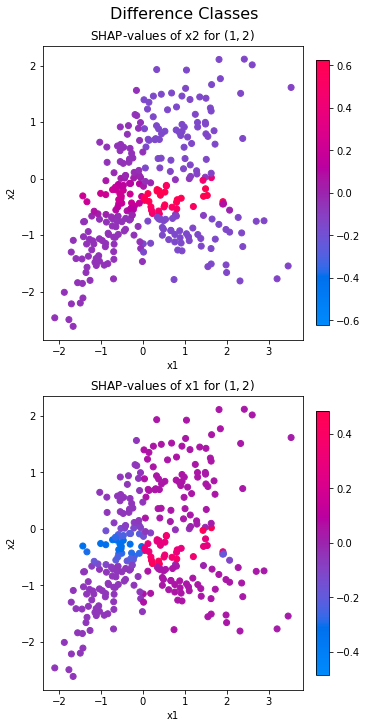

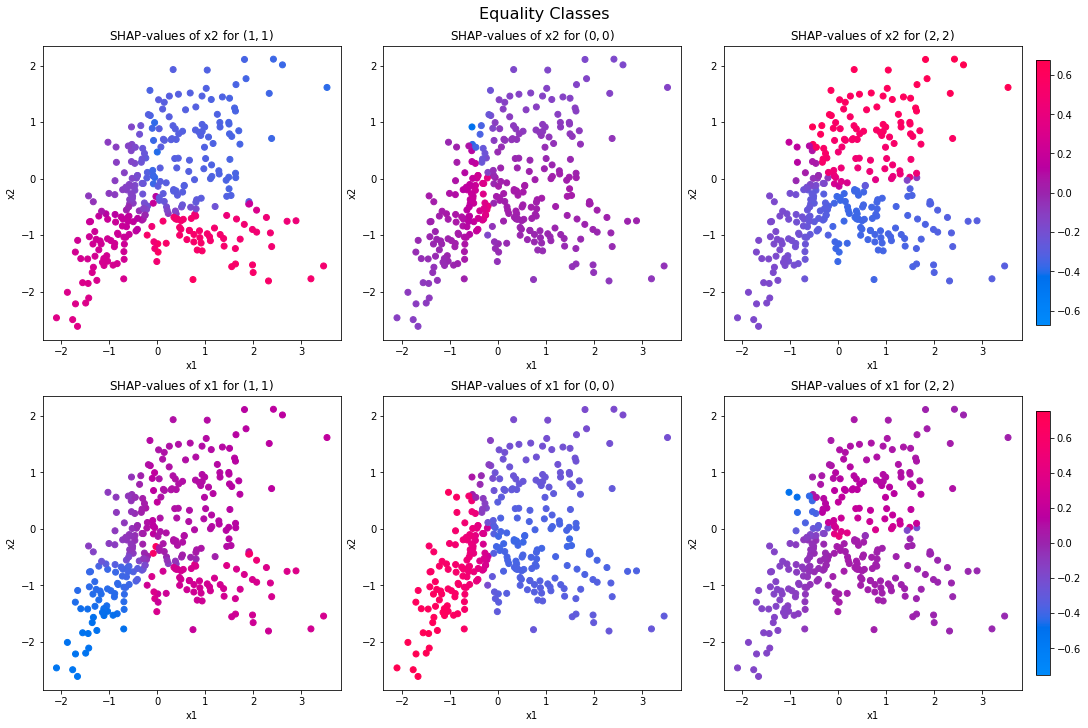

In [161]:
for class_indices, title in [(diff_clf.difference_classes_[difference_class_order][:n_informative_difference_classes], 'Difference Classes'),
                             (diff_clf.equality_classes_[equality_class_order][:n_informative_equality_classes], 'Equality Classes')]:
    n_columns = len(class_indices)
    n_rows = n_features
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(5*n_columns, 5*n_rows), constrained_layout=True)
    plot_idx = 0
    fig.suptitle(title, fontsize=16)
    for feature_idx in feature_order:
        vmax = np.max(np.abs(diff_shap_values.values[:, feature_idx, class_indices]))
        for class_idx in class_indices:
            class_tuple = diff_clf.class_tuples_[class_idx]
            ax = axs.flat[plot_idx]
            cs = ax.scatter(X[:, 0],
                            X[:, 1],
                            c=diff_shap_values.values[:, feature_idx, class_idx],
                            vmin=-vmax, vmax=vmax,
                            cmap=colors.red_blue,
                            alpha=1)
            ax.set_title(f'SHAP-values of {feature_names[feature_idx]} for ${class_tuple}$')
            ax.set_xlabel(feature_names[0])
            ax.set_ylabel(feature_names[1])
            plot_idx += 1
        fig.colorbar(cs, ax=ax, shrink=0.9)
    plt.show()

## SHAP value distribution

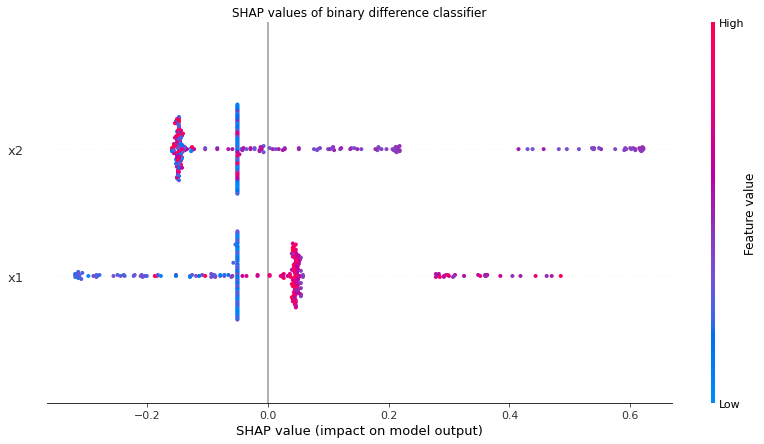

In [162]:
plt.title('SHAP values of binary difference classifier')
shap.plots.beeswarm(binary_diff_shap_values, order=feature_order, plot_size=(14, 7))

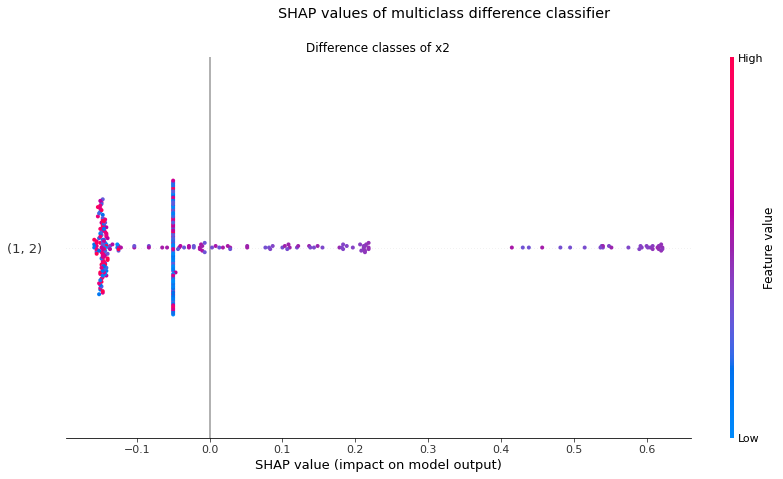

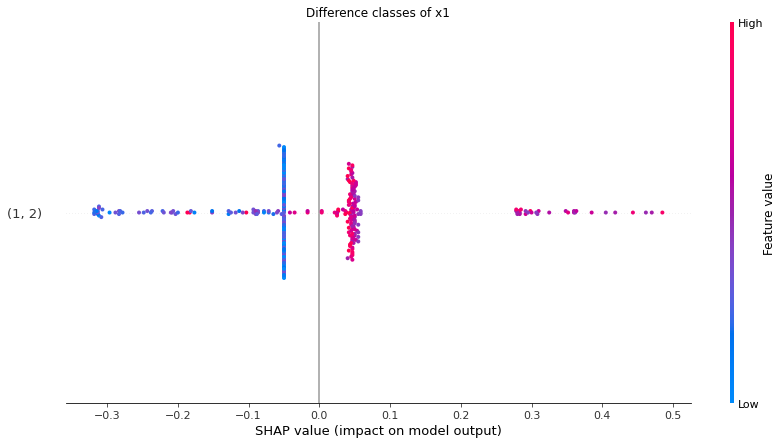

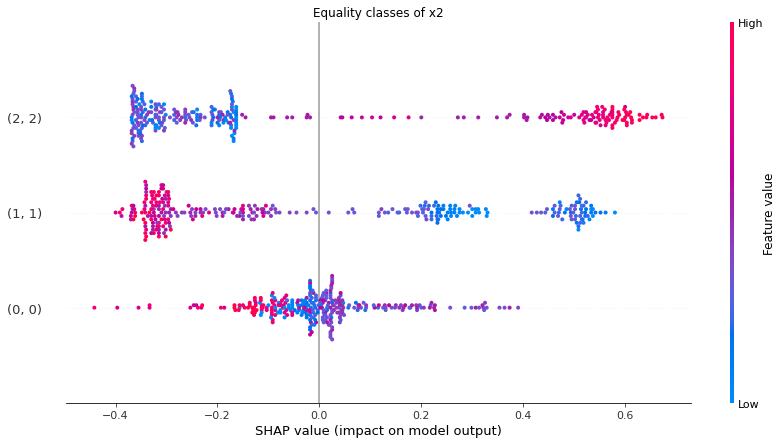

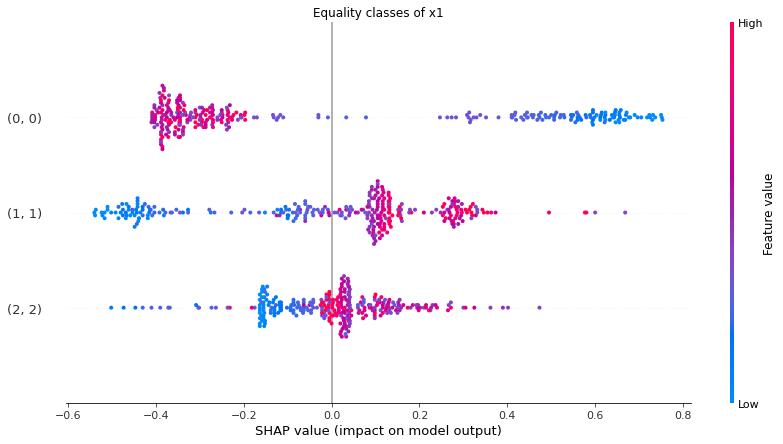

In [164]:
plt.suptitle('SHAP values of multiclass difference classifier', fontsize='x-large')
for class_indices, class_title in [(diff_clf.difference_classes_[difference_class_order][:n_informative_difference_classes], 'Difference classes'),
                                   (diff_clf.equality_classes_[equality_class_order][:n_informative_equality_classes], 'Equality classes')]:
    for feature_idx in feature_order:
        new_values = diff_shap_values.values[:, feature_idx, class_indices]
        new_data = np.reshape(np.repeat(diff_shap_values.data[:, feature_idx], len(class_indices)), (n_samples, len(class_indices)))
        if diff_shap_values.display_data is not None:
            new_display_data = np.reshape(np.repeat(diff_shap_values.display_data[:, feature_idx], len(class_indices)), (n_samples, len(class_indices)))
        else:
            new_display_data = None
        new_base_values = diff_shap_values.base_values
        class_names = [str(class_tuple) for class_tuple in diff_clf.class_tuples_[class_indices]]
        shap_values_ = shap.Explanation(new_values, new_base_values, new_data, new_display_data, feature_names=class_names)
        shap.plots.beeswarm(shap_values_, plot_size=(14, 7), show=False)
        plt.title(f'{class_title} of {feature_names[feature_idx]}')
        plt.show()

## Feature effects

### Partial dependence plots

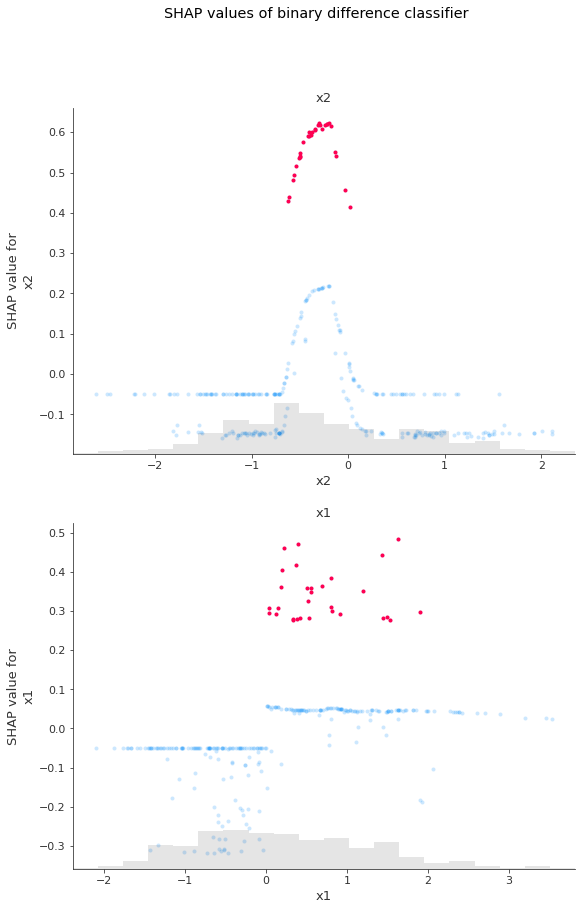

In [165]:
n_columns = 1
n_rows = n_features
fig = plt.figure(figsize=(9*n_columns, 7*n_rows))
fig.suptitle('SHAP values of binary difference classifier', fontsize='x-large')
i = 1
for feature in feature_names[feature_order]:
    ax = fig.add_subplot(n_rows, n_columns, i)
    shap.plots.scatter(binary_diff_shap_values[:, feature],
                       ax=ax,
                       color=tuple(colors.blue_rgb),
                       alpha=0.2,
                       show=False)
    shap.plots.scatter(binary_diff_shap_values[is_pred_diff, feature],
                       title=feature,
                       ax=ax,
                       color=tuple(colors.red_rgb),
                       hist=False,
                       show=False)
    i += n_columns
plt.show()

SHAP values of multiclass difference classifier

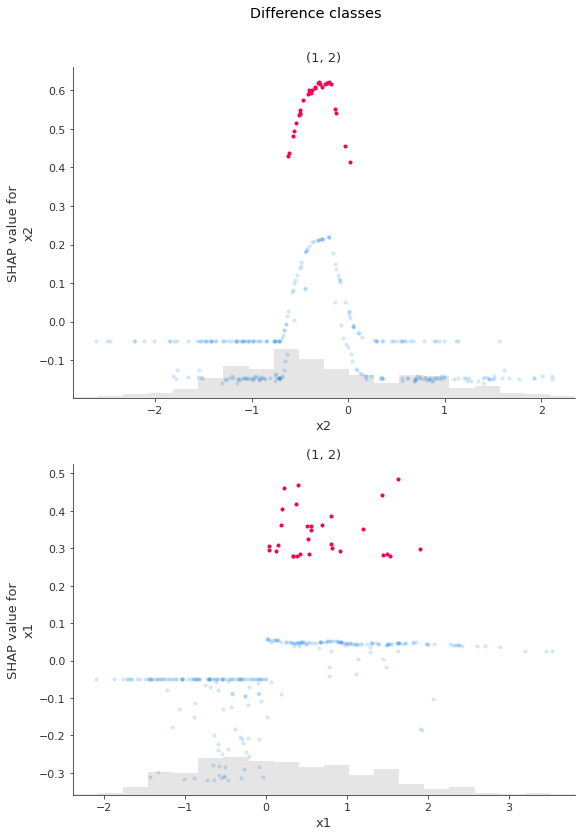

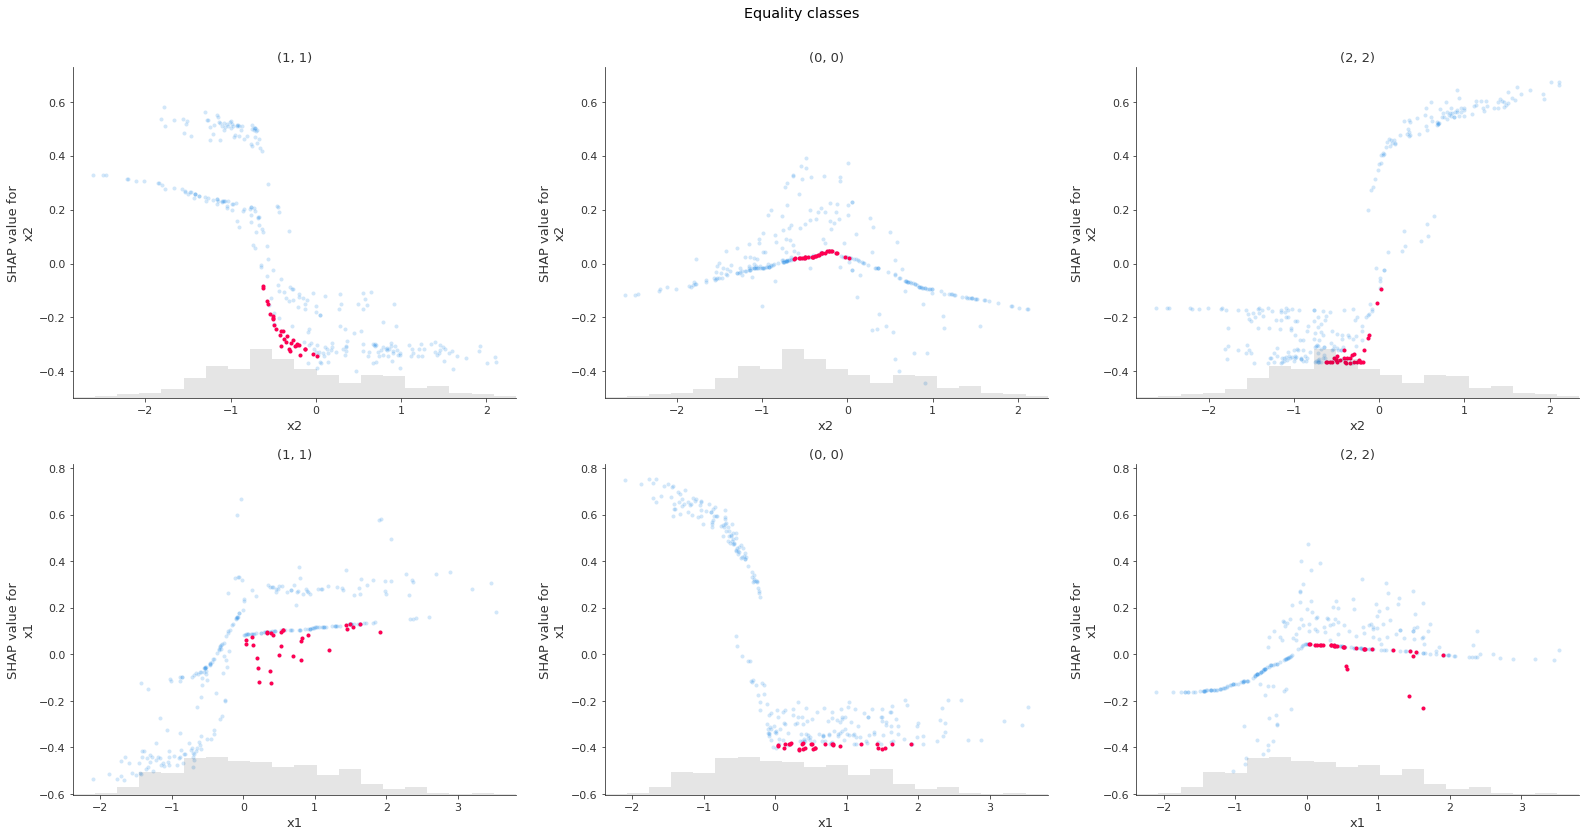

In [167]:
for class_indices, class_title in [(diff_clf.difference_classes_[difference_class_order][:n_informative_difference_classes], 'Difference classes'),
                                   (diff_clf.equality_classes_[equality_class_order][:n_informative_equality_classes], 'Equality classes')]:
    n_columns = len(class_indices)
    n_rows = n_features * 2
    fig = plt.figure(figsize=(9 * n_columns, 7 * n_rows))
    fig.suptitle(class_title, fontsize='x-large', y=0.91)
    plot_idx = 1
    for feature in feature_names[feature_order]:
        ax_ref = None
        for class_idx in class_indices:
            class_tuple = diff_clf.class_tuples_[class_idx]
            ax = fig.add_subplot(n_rows, n_columns, plot_idx, sharey=ax_ref)
            if not ax_ref:
                ax_ref = ax
            shap.plots.scatter(diff_shap_values[:, feature, class_idx],
                               ax=ax, alpha=0.2, show=False)
            if np.sum(is_pred_diff) > 0:
                shap.plots.scatter(diff_shap_values[is_pred_diff, feature, class_idx],
                                   ax=ax, title=str(class_tuple), 
                                   color=tuple(colors.red_rgb),
                                   hist=False, show=False)
            plot_idx += 1
    plt.show()